<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/Hebbian_3_neuron_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's simulate the whole thing.

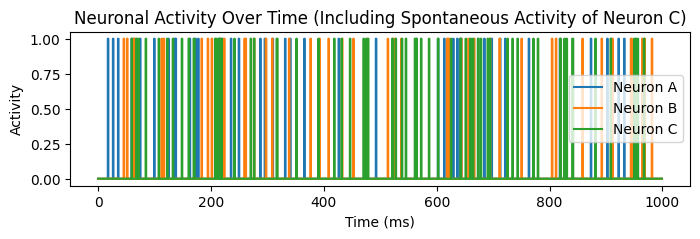

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
total_time_ms = 1000  # Total simulation time in milliseconds
prob_A_fires = 0.05  # Probability of neuron A firing spontaneously
prob_B_fires = 0.05  # Probability of neuron B firing spontaneously
prob_C_fires_spontaneously = 0.05  # Spontaneous firing probability for neuron C

delay = 8  # Delay in ms for the effect of A or B on C
prob_C_fires_from_A = 0.18  # Probability of C firing given A fired
prob_C_fires_from_B = 0.14  # Probability of C firing given B fired
prob_C_fires_from_A_and_B = 0.78  # Probability of C firing given both A and B fired

# Initialize activity arrays
activity_A = np.random.rand(total_time_ms) < prob_A_fires
activity_B = np.random.rand(total_time_ms) < prob_B_fires
activity_C = np.zeros(total_time_ms, dtype=bool)

# Simulate the activity
for t in range(total_time_ms - delay):
    if activity_A[t] and activity_B[t]:
        # Both A and B fire simultaneously
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_A_and_B)
    elif activity_A[t]:
        # Only A fires
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_A)
    elif activity_B[t]:
        # Only B fires
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_B)

# Adding spontaneous activity for C
for t in range(total_time_ms):
    activity_C[t] = activity_C[t] or (np.random.rand() < prob_C_fires_spontaneously)

# Re-plotting the visualization
plt.figure(figsize=(8, 2))
plt.plot(activity_A, label="Neuron A", drawstyle='steps-post')
plt.plot(activity_B, label="Neuron B", drawstyle='steps-post')
plt.plot(activity_C, label="Neuron C", drawstyle='steps-post')
plt.xlabel("Time (ms)")
plt.ylabel("Activity")
plt.title("Neuronal Activity Over Time (Including Spontaneous Activity of Neuron C)")
plt.legend()
plt.show()

animate

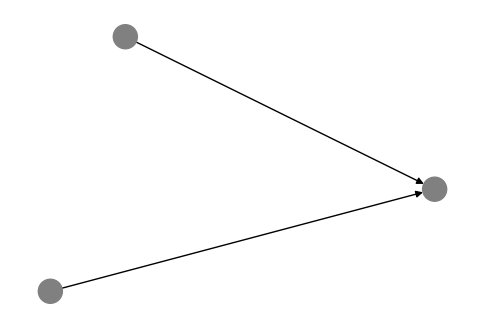

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from IPython.display import HTML

# [Your existing simulation code here to generate activity_A, activity_B, activity_C]

# Create a directed graph
G = nx.DiGraph()
G.add_node("Neuron A")
G.add_node("Neuron B")
G.add_node("Neuron C")
G.add_edge("Neuron A", "Neuron C")
G.add_edge("Neuron B", "Neuron C")
pos = nx.spring_layout(G)  # or any other layout

def update(num, G, pos, ax):
    ax.clear()
    colors = []
    for node in G:
        if node == "Neuron A" and activity_A[num]:
            colors.append('red')  # Active color for A
        elif node == "Neuron B" and activity_B[num]:
            colors.append('blue')  # Active color for B
        elif node == "Neuron C":
            if activity_A[num] and activity_B[num]:
                colors.append('purple')  # Combined color for A and B
            elif activity_C[num]:
                colors.append('green')  # Active color for C
            else:
                colors.append('gray')  # Inactive color for C
        else:
            colors.append('gray')  # Inactive color for A and B

    nx.draw(G, pos, ax=ax, node_color=colors, with_labels=False)

fig, ax = plt.subplots(figsize=(6, 4))
ani = animation.FuncAnimation(fig, update, frames=total_time_ms, fargs=(G, pos, ax), interval=100)

# Convert to HTML and display
HTML(ani.to_html5_video())

cross-correlograms

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Simulation parameters
extended_total_time_ms = 10000000  # Extended total simulation time in milliseconds
prob_A_fires = 0.05  # Probability of neuron A firing spontaneously
prob_B_fires = 0.05  # Probability of neuron B firing spontaneously
prob_C_fires_spontaneously = 0.05  # Spontaneous firing probability for neuron C
delay = 8  # Delay in ms for the effect of A or B on C
prob_C_fires_from_A = 0.18  # Probability of C firing given A fired
prob_C_fires_from_B = 0.14  # Probability of C firing given B fired
prob_C_fires_from_A_and_B = 0.78  # Probability of C firing given both A and B fired

# Initialize extended activity arrays
extended_activity_A = np.random.rand(extended_total_time_ms) < prob_A_fires
extended_activity_B = np.random.rand(extended_total_time_ms) < prob_B_fires
extended_activity_C = np.zeros(extended_total_time_ms, dtype=bool)

# Simulate the extended activity
for t in range(extended_total_time_ms - delay):
    if extended_activity_A[t] and extended_activity_B[t]:
        extended_activity_C[t + delay] = np.random.rand() < prob_C_fires_from_A_and_B
    elif extended_activity_A[t]:
        extended_activity_C[t + delay] = np.random.rand() < prob_C_fires_from_A
    elif extended_activity_B[t]:
        extended_activity_C[t + delay] = np.random.rand() < prob_C_fires_from_B

# Adding spontaneous activity for C in the extended array
for t in range(extended_total_time_ms):
    extended_activity_C[t] = extended_activity_C[t] or (np.random.rand() < prob_C_fires_spontaneously)

# Transforming to Spike Density Function (SDF)
def to_sdf(activity, sigma_ms):
    """ Convert a spike train to a spike density function using a Gaussian kernel """
    window_size = int(3 * sigma_ms)
    gaussian_kernel = np.exp(-np.arange(-window_size, window_size+1)**2 / (2 * sigma_ms**2))
    gaussian_kernel /= np.sum(gaussian_kernel)
    sdf = np.convolve(activity, gaussian_kernel, mode='same')
    return sdf

# Standard deviation for Gaussian kernel in ms
sigma_ms = 5

# Calculate SDFs
sdf_A = to_sdf(extended_activity_A, sigma_ms)
sdf_B = to_sdf(extended_activity_B, sigma_ms)
sdf_C = to_sdf(extended_activity_C, sigma_ms)

# Function to calculate correlogram and lags
def calculate_correlogram_and_lags(signal1, signal2, max_lag_ms):
    corr = correlate(signal1, signal2, mode='full', method='auto')
    middle = len(corr) // 2
    lags = np.arange(-middle, middle + 1)
    return lags, corr

# Set the maximum lag in milliseconds for the correlogram
max_lag_ms = 20

# Calculate cross-correlograms with the SDFs
lags_sdf_AA, corr_sdf_AA = calculate_correlogram_and_lags(sdf_A, sdf_A, max_lag_ms)
lags_sdf_BB, corr_sdf_BB = calculate_correlogram_and_lags(sdf_B, sdf_B, max_lag_ms)
lags_sdf_CC, corr_sdf_CC = calculate_correlogram_and_lags(sdf_C, sdf_C, max_lag_ms)
lags_sdf_AB, corr_sdf_AB = calculate_correlogram_and_lags(sdf_A, sdf_B, max_lag_ms)
lags_sdf_AC, corr_sdf_AC = calculate_correlogram_and_lags(sdf_A, sdf_C, max_lag_ms)
lags_sdf_BC, corr_sdf_BC = calculate_correlogram_and_lags(sdf_B, sdf_C, max_lag_ms)
lags_sdf_BA, corr_sdf_BA = calculate_correlogram_and_lags(sdf_B, sdf_A, max_lag_ms)
lags_sdf_CA, corr_sdf_CA = calculate_correlogram_and_lags(sdf_C, sdf_A, max_lag_ms)
lags_sdf_CB, corr_sdf_CB = calculate_correlogram_and_lags(sdf_C, sdf_B, max_lag_ms)

# Function to limit the plot range
def limit_plot_range(lags, corr, range_ms=20):
    """ Limit the plot range to +/- range_ms """
    within_range = (lags >= -range_ms) & (lags <= range_ms)
    return lags[within_range], corr[within_range]

# Apply the range limitation
limited_lags_sdf_AA, limited_corr_sdf_AA = limit_plot_range(lags_sdf_AA, corr_sdf_AA)
limited_lags_sdf_BB, limited_corr_sdf_BB = limit_plot_range(lags_sdf_BB, corr_sdf_BB)
limited_lags_sdf_CC, limited_corr_sdf_CC = limit_plot_range(lags_sdf_CC, corr_sdf_CC)
limited_lags_sdf_AB, limited_corr_sdf_AB = limit_plot_range(lags_sdf_AB, corr_sdf_AB)
limited_lags_sdf_AC, limited_corr_sdf_AC = limit_plot_range(lags_sdf_AC, corr_sdf_AC)
limited_lags_sdf_BC, limited_corr_sdf_BC = limit_plot_range(lags_sdf_BC, corr_sdf_BC)
limited_lags_sdf_BA, limited_corr_sdf_BA = limit_plot_range(lags_sdf_BA, corr_sdf_BA)
limited_lags_sdf_CA, limited_corr_sdf_CA = limit_plot_range(lags_sdf_CA, corr_sdf_CA)
limited_lags_sdf_CB, limited_corr_sdf_CB = limit_plot_range(lags_sdf_CB, corr_sdf_CB)

normalize

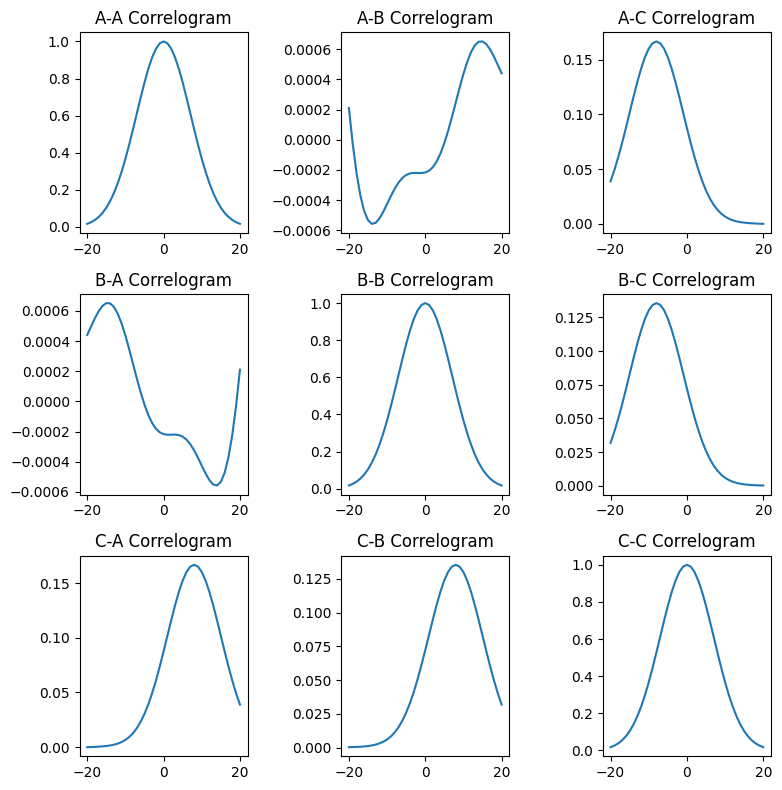

In [7]:
def normalized_cross_correlation(signal1, signal2, max_lag_ms):
    corr = correlate(signal1 - signal1.mean(), signal2 - signal2.mean(), mode='full', method='auto')
    # Normalizing the correlation
    normalization_factor = np.sqrt(np.sum((signal1 - signal1.mean())**2) * np.sum((signal2 - signal2.mean())**2))
    corr_normalized = corr / normalization_factor
    middle = len(corr) // 2
    lags = np.arange(-middle, middle + 1)
    return lags, corr_normalized

# Calculate normalized cross-correlograms with the SDFs
lags_norm_AA, corr_norm_AA = normalized_cross_correlation(sdf_A, sdf_A, max_lag_ms)
lags_norm_BB, corr_norm_BB = normalized_cross_correlation(sdf_B, sdf_B, max_lag_ms)
lags_norm_CC, corr_norm_CC = normalized_cross_correlation(sdf_C, sdf_C, max_lag_ms)
lags_norm_AB, corr_norm_AB = normalized_cross_correlation(sdf_A, sdf_B, max_lag_ms)
lags_norm_AC, corr_norm_AC = normalized_cross_correlation(sdf_A, sdf_C, max_lag_ms)
lags_norm_BC, corr_norm_BC = normalized_cross_correlation(sdf_B, sdf_C, max_lag_ms)
lags_norm_BA, corr_norm_BA = normalized_cross_correlation(sdf_B, sdf_A, max_lag_ms)
lags_norm_CA, corr_norm_CA = normalized_cross_correlation(sdf_C, sdf_A, max_lag_ms)
lags_norm_CB, corr_norm_CB = normalized_cross_correlation(sdf_C, sdf_B, max_lag_ms)

# Apply the range limitation to normalized correlograms
limited_lags_norm_AA, limited_corr_norm_AA = limit_plot_range(lags_norm_AA, corr_norm_AA)
limited_lags_norm_BB, limited_corr_norm_BB = limit_plot_range(lags_norm_BB, corr_norm_BB)
limited_lags_norm_CC, limited_corr_norm_CC = limit_plot_range(lags_norm_CC, corr_norm_CC)
limited_lags_norm_AB, limited_corr_norm_AB = limit_plot_range(lags_norm_AB, corr_norm_AB)
limited_lags_norm_AC, limited_corr_norm_AC = limit_plot_range(lags_norm_AC, corr_norm_AC)
limited_lags_norm_BC, limited_corr_norm_BC = limit_plot_range(lags_norm_BC, corr_norm_BC)
limited_lags_norm_BA, limited_corr_norm_BA = limit_plot_range(lags_norm_BA, corr_norm_BA)
limited_lags_norm_CA, limited_corr_norm_CA = limit_plot_range(lags_norm_CA, corr_norm_CA)
limited_lags_norm_CB, limited_corr_norm_CB = limit_plot_range(lags_norm_CB, corr_norm_CB)

# Re-plotting the normalized correlograms with limited range
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

# Plot each normalized correlogram with limited range
axs[0, 0].plot(limited_lags_norm_AA, limited_corr_norm_AA)
axs[0, 0].set_title("A-A Correlogram")
axs[0, 1].plot(limited_lags_norm_AB, limited_corr_norm_AB)
axs[0, 1].set_title("A-B Correlogram")
axs[0, 2].plot(limited_lags_norm_AC, limited_corr_norm_AC)
axs[0, 2].set_title("A-C Correlogram")

axs[1, 0].plot(limited_lags_norm_BA, limited_corr_norm_BA)
axs[1, 0].set_title("B-A Correlogram")
axs[1, 1].plot(limited_lags_norm_BB, limited_corr_norm_BB)
axs[1, 1].set_title("B-B Correlogram")
axs[1, 2].plot(limited_lags_norm_BC, limited_corr_norm_BC)
axs[1, 2].set_title("B-C Correlogram")

axs[2, 0].plot(limited_lags_norm_CA, limited_corr_norm_CA)
axs[2, 0].set_title("C-A Correlogram")
axs[2, 1].plot(limited_lags_norm_CB, limited_corr_norm_CB)
axs[2, 1].set_title("C-B Correlogram")
axs[2, 2].plot(limited_lags_norm_CC, limited_corr_norm_CC)
axs[2, 2].set_title("C-C Correlogram")

plt.tight_layout()
plt.show()